In [68]:
# Import packages
import numpy as np
import tomopy
import cv2
import matplotlib.pyplot as plt
from skimage.transform import rotate, AffineTransform
import tifffile

In [53]:
# Creating ground truth tomography
data = tomopy.shepp3d(256)
ang = tomopy.angles(181)
proj = tomopy.project(data, ang)

In [54]:
# Randomly determined misalignment axis
mis_axis = np.random.normal(0, 1, (200, 3))
mis_axis[:, :1] = mis_axis[:, :1]*4
mis_axis = np.round(mis_axis).astype(int)

In [55]:
# Define function for artificial misalignment
def misalign(prj, mis_axis, ang_tilt = False, noise = False, background = False):
    num_prj, col, row = prj.shape
    prj_tmp = np.zeros_like(prj)
    for i in range(num_prj):
        d_row, d_col, d_ang = mis_axis[i]
        if ang_tilt == True:
            prj_tmp[i, :, :] = rotate(prj[i,:,:], d_ang)
        else:
            prj_tmp[i, :, :] = prj[i,:,:]
        translation_matrix = np.float32([ [1,0,d_row], [0,1,d_col] ])
        prj_tmp[i, :, :] = cv2.warpAffine(prj_tmp[i, :, :], translation_matrix, (row, col))
        if noise == True:
            prj_tmp[i, :, :] = random_noise(prj_tmp[i, :, :], mode = 'gaussian')
        if background == True:
            prj_tmp[i, :, :] = prj_tmp[i, :, :]+np.random.random()/5
            prj_tmp[i, :, :] = prj_tmp[i, :, :]/prj_tmp[i, :, :].max()
    return prj_tmp

In [56]:
# Creating misaligned projections
proj_mis = misalign(proj, mis_axis, ang_tilt = True)

In [57]:
# Creating realigned projection using joint alignment
proj_align = tomopy.align_joint(proj_mis.copy(), ang, iters = 10, algorithm = 'sirt')

iter=0, err=0.26827115844508487
iter=1, err=0.01651924498428804
iter=2, err=0.006811507308303778
iter=3, err=0.004350280658200923
iter=4, err=0.003706190073181987
iter=5, err=0.0028171378947923183
iter=6, err=0.0024707933898313965
iter=7, err=0.002344000414552242
iter=8, err=0.0016574585882339688
iter=9, err=0.0016574585882339688


In [58]:
# Apply translations to original
x_translation = proj_align[1]
y_translation = proj_align[2]

# Initialize realigned projection
proj_re = np.zeros(proj_mis.shape)

# Number of rows and columns in each projection
num_rows, num_cols = proj_mis[0].shape

# Translate each image
count = 0
for image in proj_mis:
    translation_matrix = np.float32([ [1, 0, x_translation[count]], [0, 1, y_translation[count]] ])
    image_translation = cv2.warpAffine(image, translation_matrix, (num_cols, num_rows))
    proj_re[count] = image_translation
    count += 1

In [71]:
print(np.array_equiv(proj_mis[0, :, :], proj_re[0, :, :]))
print(proj_align[1][0])
print(proj_align[2][0])

False
3.0
-6.399999909102917


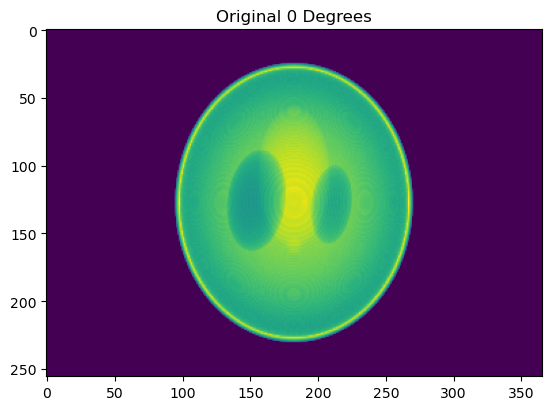

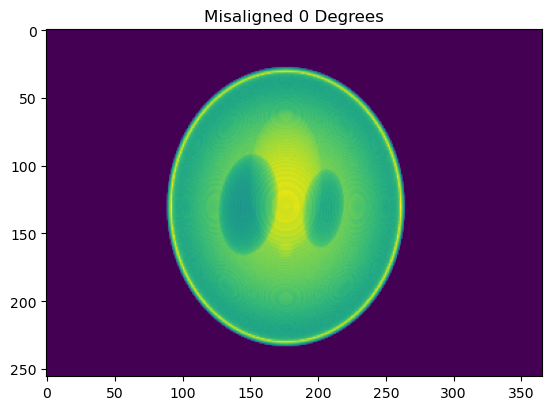

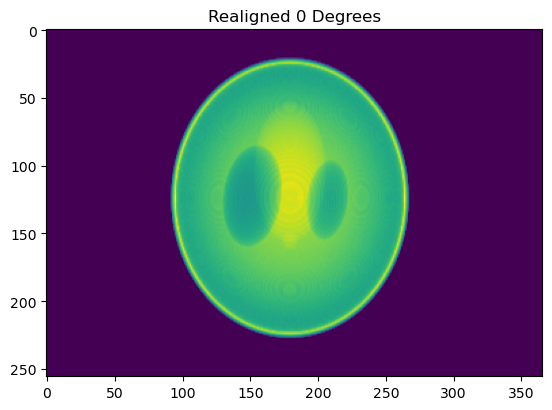

In [60]:
# Projection for original
plt.imshow(proj[0, :, :])
plt.title('Original 0 Degrees')
plt.show()

# Projection for misaligned
plt.imshow(proj_mis[0, :, :])
plt.title('Misaligned 0 Degrees')
plt.show()

# Projection for realigned
plt.imshow(proj_re[0, :, :])
plt.title('Realigned 0 Degrees')
plt.show()

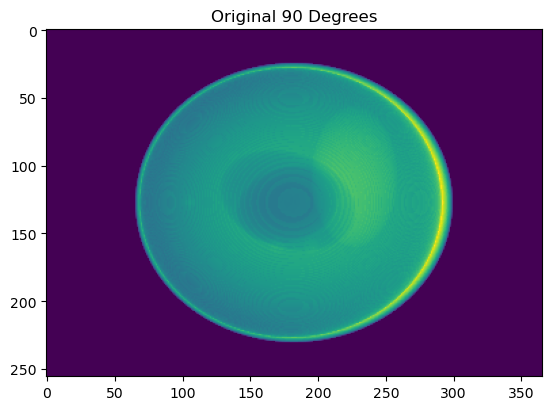

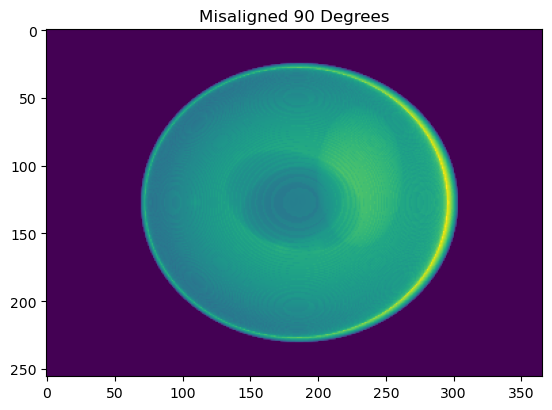

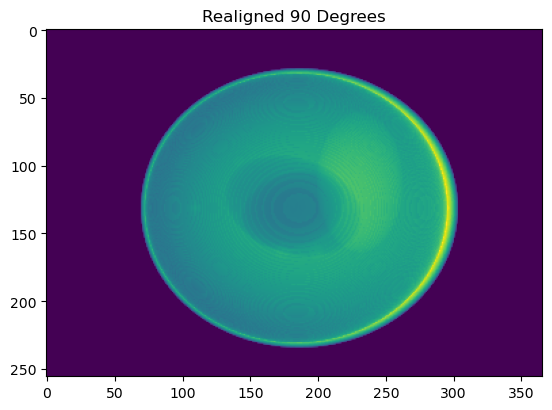

In [61]:
# Projection for original
plt.imshow(proj[90, :, :])
plt.title('Original 90 Degrees')
plt.show()

# Projection for misaligned
plt.imshow(proj_mis[90, :, :])
plt.title('Misaligned 90 Degrees')
plt.show()

# Projection for realigned
plt.imshow(proj_re[90, :, :])
plt.title('Realigned 90 Degrees')
plt.show()

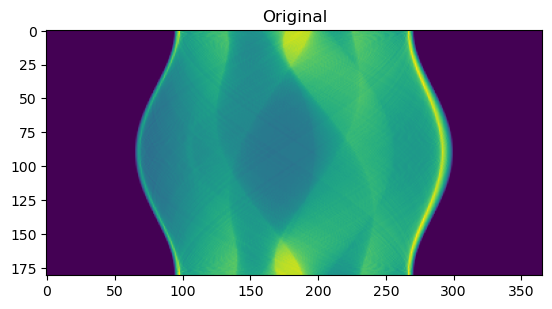

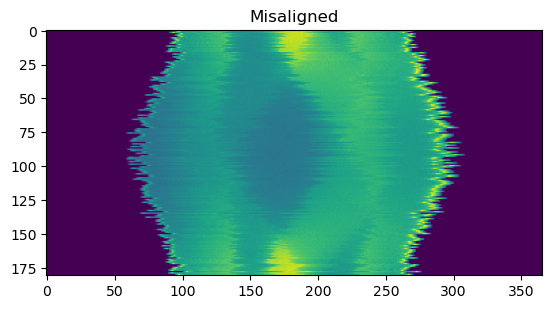

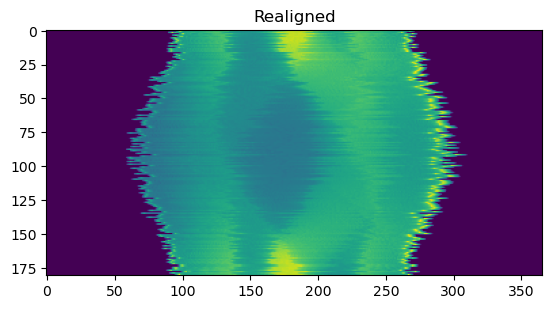

In [62]:
# Sinogram for original
plt.imshow(proj[:, 128, :])
plt.title('Original')
plt.show()

# Sinogram for misaligned
plt.imshow(proj_mis[:, 128, :])
plt.title('Misaligned')
plt.show()

# Sinogram for realigned
plt.imshow(proj_re[:, 128, :])
plt.title('Realigned')
plt.show()

In [66]:
# Create tomographic reconstructions
recon = tomopy.recon(proj, ang, algorithm='gridrec', sinogram_order=False)
recon_mis = tomopy.recon(proj_mis, ang, algorithm='gridrec', sinogram_order=False)
recon_re = tomopy.recon(proj_re, ang, algorithm='gridrec', sinogram_order=False)

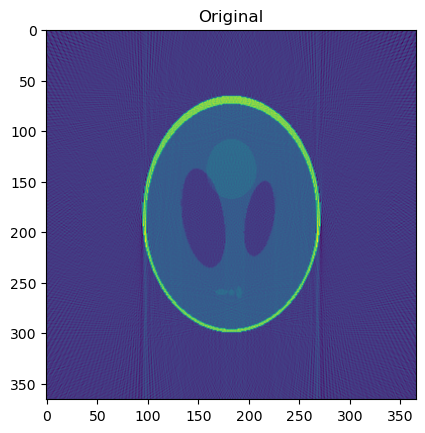

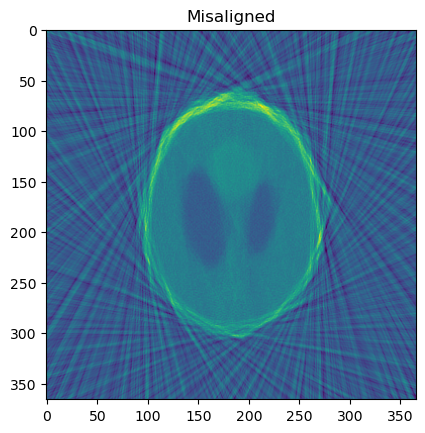

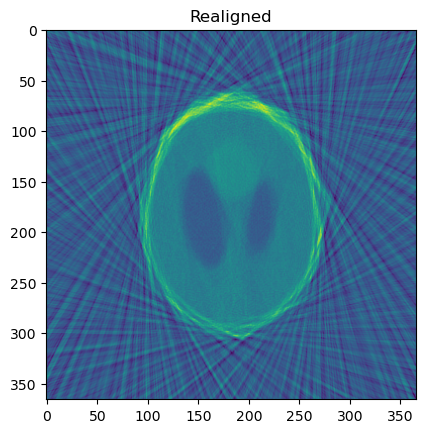

In [67]:
# Reconstruction for original
plt.imshow(recon[128])
plt.title('Original')
plt.show()

# Reconstruction for misaligned
plt.imshow(recon_mis[128])
plt.title('Misaligned')
plt.show()

# Reconstruction for realigned
plt.imshow(recon_re[128])
plt.title('Realigned')
plt.show()